In [1]:
%load_ext autoreload
%autoreload 2

# Getting the data

In [8]:
import os, sys
from helpers.highlevel_sceneloader import HighLevelSceneLoader
from predictors.dataset_creator import TFDataSet
import tensorflow as tf
from predictors.dl_trainer import DLTrainer 
from predictors.extended_predictor import extended_predictor 
import matplotlib.pyplot as plt
import pickle
from helpers.graph import Graph
import numpy as np

import warnings
warnings.filterwarnings('ignore')


''' set some parameters '''
# Model parameters
LSTM_LAYER_SIZE = 32
DENSE_LAYER_SIZE = 32
NUM_LSTM_LAYERS = 2
NUM_DENSE_LAYERS = 2
VARIABLE_INPUT_LENGTH = False

# Dataset
SEQ_IN_LEN = 3
SEQ_OUT_LEN = 4
NOISE_STD = .1
N_REPEATS = 1

BATCH_SIZE = 5
LENGTH_STRIDE = 2


# Training parameters
MAX_EPOCHS = 100
PATIENCE = 10

# For graph
GRAPH_DIST_THRESH = 4

''' get the data '''
ROOT = os.getcwd()

rel_p_img_b = 'helpers/analysed_vars_storage/img_bounds.xml'
rel_p_dests = 'helpers/analysed_vars_storage/destination_locations.xml'
p_img_bounds = os.path.join(ROOT, rel_p_img_b)
p_dest_locs = os.path.join(ROOT, rel_p_dests)

#TODO: older version of OpenTraj needed: "git checkout d249ba6951dd0f54b532fbe2ca6edc46b0d7093f"
opentraj_root = os.path.join(ROOT, 'OpenTraj')
root_datasets = os.path.join(ROOT, 'data/path_data')
sys.path.append(opentraj_root) # add package to pythonpath

scene_data = HighLevelSceneLoader(p_img_bounds, p_dest_locs)
scene_data.load_ind(root_datasets, 7, 17)

scene_data2 = HighLevelSceneLoader(p_img_bounds, p_dest_locs)
scene_data2.load_sdd(opentraj_root, "little", "video3")

# ''' create the graph instance '''    
# interest_points = __return_waypoints_ind()
# g = Graph.from_matrices(interest_points, scene_data.destination_matrix, GRAPH_DIST_THRESH, .05)

# df_signals = scene_data.df_to_lst_realxy_mats()
# g.analyse_multiple_full_signals(df_signals, add_to_trams_mat=True)


<Element 'dataset' at 0x7f2502b79e50>
<Element 'dataset' at 0x7f258c0b3540>
<Element 'dataset' at 0x7f25100cbc20>
<Element 'dataset' at 0x7f2502b76f90>


In [9]:
print(len(scene_data2.traj_dataframe ))
print(len(scene_data.traj_dataframe ))
print(len(scene_data.traj_dataframe )/len(scene_data2.traj_dataframe ))

3784
18106
4.784883720930233


In [13]:
len(scene_data.traj_dataframe["agent_id"].unique())
print(794/92)

8.630434782608695


In [ ]:

id_col = 'agent_id'
start_df = scene_data.traj_dataframe.copy()
dest_df = scene_data.traj_dataframe.copy()
dest_df[id_col + 'copy'] = dest_df[id_col].shift(-1)
start_df[id_col + 'copy'] = start_df[id_col].shift(1)
dest_df = dest_df.loc[dest_df[id_col]!=dest_df[id_col + 'copy']]
start_df = start_df.loc[start_df[id_col]!=start_df[id_col + 'copy']]
full_df = start_df.append(dest_df)

In [ ]:
id_col2 = 'agent_id'
start_df2 = scene_data2.traj_dataframe.copy()
dest_df2 = scene_data2.traj_dataframe.copy()
dest_df2[id_col2 + 'copy'] = dest_df2[id_col2].shift(-1)
start_df2[id_col2 + 'copy'] = start_df2[id_col2].shift(1)
dest_df2 = dest_df2.loc[dest_df2[id_col2]!=dest_df2[id_col2 + 'copy']]
start_df2 = start_df2.loc[start_df2[id_col2]!=start_df2[id_col2 + 'copy']]
full_df2 = start_df2.append(dest_df2)

In [ ]:
d = dest_df[["pos_x", "pos_y"]].to_numpy()
s = start_df[["pos_x", "pos_y"]].to_numpy()

In [ ]:
d2 = dest_df2[["pos_x", "pos_y"]].to_numpy()
s2 = start_df2[["pos_x", "pos_y"]].to_numpy()

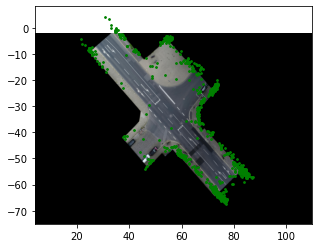

In [ ]:
scene_data.plot_on_image([d],colors = ["green"])

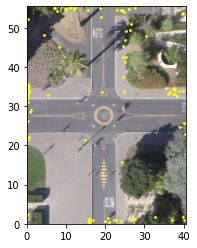

In [ ]:
scene_data2.plot_on_image([d2],colors = ["yellow"])

# Clustering

In [ ]:
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [ ]:
def plot_clustered_elements(d, n_clusters, file_address = None):
    scaler_d = StandardScaler()
    scaled_d = scaler_d.fit_transform(d)

    kmeans_d = KMeans(
        init="random",
        n_clusters=n_clusters,
        n_init=3*n_clusters,
        max_iter=30000,
        random_state=42)

    kmeans_d.fit(scaled_d)
    kmeans_d_pred = scaler_d.inverse_transform(kmeans_d.cluster_centers_)

    return scene_data.plot_on_image([d, kmeans_d_pred],colors = ["green", "yellow"],
    hide_axes=True, ms=[7,30], labels=["endpoints", "detected POIs"], save_path=file_address)


number of estimated clusters : 9


Text(0.5, 1.0, 'Estimated number of clusters: 9')

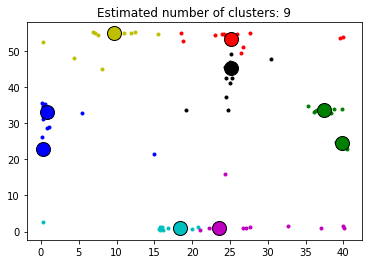

In [ ]:
# bandwidth = estimate_bandwidth(d, quantile=0.2, n_samples=500)
bandwidth = 5

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, min_bin_freq=3)
ms.fit(d2)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(d2[my_members, 0], d2[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)

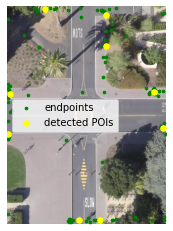

In [55]:
fig, ax = plt.subplots()
scene_data2.plot_on_image([d2, cluster_centers],colors = ["green", "yellow"], ax=ax, 
hide_axes=True, ms=[7,30], labels=["endpoints", "detected POIs"], save_path="data/images/meanshift.png")
ax.grid(False)

In [57]:
cluster_centers

array([[ 0.80188993, 33.06466289],
       [37.4084038 , 33.74739443],
       [25.14758057, 53.29443775],
       [18.44346834,  0.86828017],
       [23.60483923,  0.91962773],
       [ 9.62586124, 54.87695537],
       [25.12452065, 45.36610442],
       [ 0.29354899, 22.89682134],
       [39.78424137, 24.5101475 ]])

Text(0.5, 1.0, 'Estimated number of clusters: 9')

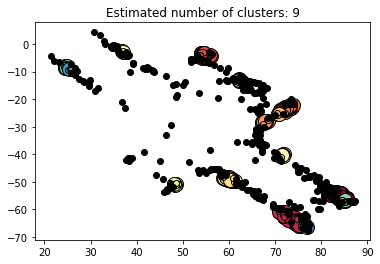

In [56]:
# Compute DBSCAN
db = DBSCAN(min_samples=5).fit(d)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = d[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = d[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)

## Destinations

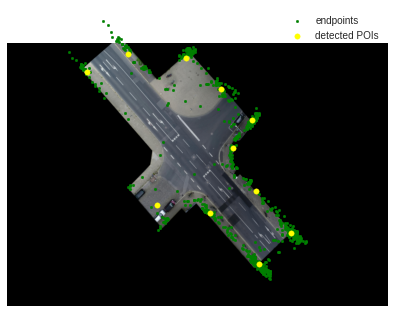

In [63]:
plot_clustered_elements(d, 11, file_address="data/images/kmeans.png")

## Starting points

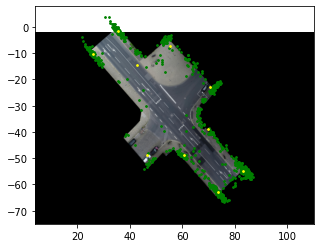

In [10]:
plot_clustered_elements(s, 10)

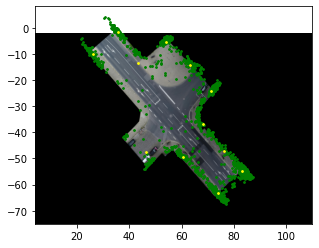

In [11]:
ds = np.concatenate([d,s], axis = 0)
plot_clustered_elements(ds, 12)

## Guess the number of clusters

### Elbow

In [12]:
from yellowbrick.cluster import KElbowVisualizer

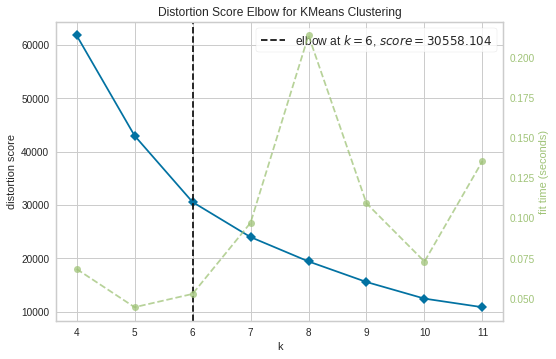

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
def elbow(d):
    visualizer = KElbowVisualizer(KMeans(), k=(4,12))

    visualizer.fit(d)        # Fit the data to the visualizer
    return visualizer.show()        # Finalize and render the figure
elbow(d)

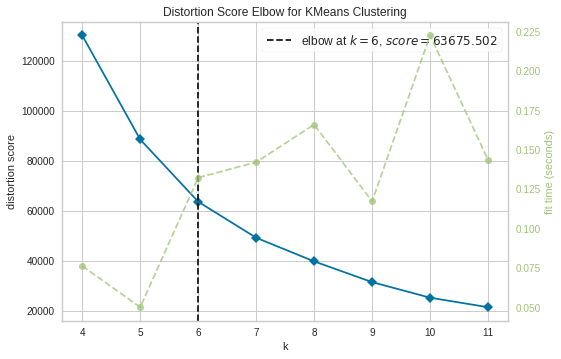

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
elbow(ds)

### Silhouette Score

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = list(range(4,14))           # clusters range you want to select
dataToFit = d  # sample data
best_clusters = 0                       # best cluster number which you will get
previous_silh_avg = 0.0

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(dataToFit)
    silhouette_avg = silhouette_score(dataToFit, cluster_labels)
    if silhouette_avg > previous_silh_avg:
        previous_silh_avg = silhouette_avg
        best_clusters = n_clusters

# Final Kmeans for best_clusters
kmeans = KMeans(n_clusters=best_clusters, random_state=0).fit(ds)
best_clusters

12

### Method 3?